In [1]:
# The code was removed by Watson Studio for sharing.

# Applied Data Science Capstone Project

## Battle of the Neighborhoods

Jose Escobar


## Introduction <a name="introduction"></a>


__New York__ is one of the most popular cities in __United States__, it is divided into 5 boroughs and more then 300 neighborhoods with dozens of restaurants each. As the city has a rich gastronomy, not only its own, but from other countries such as Chinese, Mexican, Italian and many more, there are plenty of restaurants, so it is considered one of the most common work and one of the easiest to start a small business. But just as it is easy to start a food business, it is quite difficult to get people's attention and satisfaction when it comes to food, more so when there is competition with other restaurants or food chains with more time in the sector and greater popularity. The possibility of success is affected by the number of existing restaurants, their popularity and the type of food served.

With that in mind, I will try to find the __best areas__ to open a restaurant where the ___competition is low for certain gastronomic themes___.
Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders interested in opening a restaurant in this city.

## Data <a name="data"></a>

Based on the problem, the following necessary data sets can be identified:
* Coordinates of the different neighborhoods in the city
* Restaurants near or within the city's neighborhoods.


For neighborhoods, there is free dataset on the web that can be found here:https://geo.nyu.edu/catalog/nyu_2451_34572 and it is the same used in previous labs of the course.

Here is an example of the data:

<table>
    <thead>
        <tr>
            <th>Borough</th>           
            <th>Neighborhood</th>
            <th>Latitude</th>
            <th>Longitude</th>
        </tr>
    </thead>
    <tbody>
        <tr>
        <td>Bronx</td>
        <td>Wakefield</td>
        <td>40.894705</td>
        <td>-73.847201</td>
        </tr>
    </tbody>
</table>

For restaurants, FourSquare API will be used which will provide different data of the restaurants of each neighborhood, mainly the __type or category__ of the restaurants.

For example:
<table>
    <thead>
        <tr>
            <th>Restaurant Name</th>
            <th>Category</th>
            <th>Latitude</th>
            <th>Longitude</th>
        </tr>
    </thead>
    <tbody>
        <tr>
        <td>Ali's Roti Shop</td>
        <td>Caribbean</td>
        <td>40.8940357</td>
        <td>-73.8569349</td>
        </tr>
        <tr>
        <td>Ripe Kitchen & Bar</td>
        <td>Caribbean</td>
        <td>40.8981517</td>
        <td>-73.838875</td>
        </tr>
    </tbody>
</table>

By using this data and machine learning techniques, I'll hope to find the best model posible to cluster these neighborhoods and analyse each to get new and valuable information

### Downloading locations

Before getting the data, let's first import all the necessary dependencies

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as  plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

As mentioned, there are a total of 5 boroughs and more than 300 neighborhoods in the city. In order to segement the neighborhoods and explore them, the data must be downloaded first.

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


Let's load the file

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

The data is in json format an require some processing before using it. The main key in _features_ where all the neightborhoods are listed.
Let's loop through it and create a dataframe with the corresponding data.

In [5]:
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude'])

# looping through the data
for data in newyork_data['features']:
    borough = data['properties']['borough'] 
    name = data['properties']['name']
        
    lon,lat = data['geometry']['coordinates']
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': name,
                                          'Latitude': lat,
                                          'Longitude': lon}, ignore_index=True)

Let's look at the first five rows and check if it's okay

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Check how many neighborhoods are in the dataframe

In [7]:
neighborhoods.shape[0]

306

Great, there are a total of 306 neighborhoods corresponding to the 5 boroughs of New York.

### Create a map of New York

Let's __visualize__ the diferent neighborhoods of the city in a __map__ using Folium lib.

Use geopy library to get the latitude and longitude values of New York.

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer_joanesco")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address,ny_latitude, ny_longitude))

The geograpical coordinate of New York City, NY are 40.7127281, -74.0060152.


Create a map an adding all the points with a radius of 500. The radius helps to visualize the perimeter assumed for each neighborhood.

In [9]:
map_ny = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11)

# add markers to map
for name,lat,lng in zip(neighborhoods["Neighborhood"],neighborhoods["Latitude"],neighborhoods["Longitude"]):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.6,
        parse_html=False).add_to(map_ny)
    
map_ny

### Foursquare API

Let's use the Foursquare API to get data on restaurants in each neighborhood. 


I'm interested in any kind of restaurants like Mexican, Italian, fast food restaurants. Neighborhoods with food-related locations that are not categorized as restaurants, such as cafeterias, bakeries, and others, will not be considered. It is necessary to use the proper category id so Foursqueare APi return all the required data.   

From the documentation (https://developer.foursquare.com/docs/build-with-foursquare/categories/), the category id for __Food__ is __4d4b7105d754a06374d81259__ and includes all subcategories (Mexican, Chinese, Buffet, Dessert).

In [10]:
# The code was removed by Watson Studio for sharing.

In [11]:
#Number of results 
LIMIT = 100

#the radius to search within, in meters
radius = 500

#The food category id 
food_category="4d4b7105d754a06374d81259"

venues_list=[]
print("Getting vanues ")
for borough, name, lat, lng in zip(neighborhoods["Borough"],neighborhoods['Neighborhood'],neighborhoods['Latitude'],neighborhoods['Longitude']):
    print(". ",end='')
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT,
        food_category)
    results = requests.get(url).json()
    try:
        venues = results['response']['groups'][0]['items']
    except KeyError:
        print(results)
        pass

    venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venues])

ny_food = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
ny_food.columns = [ "Borough",'Neighborhood', 'Neighborhood Latitude', 
                          'Neighborhood Longitude', 'Venue', 
                          'Venue Latitude', 'Venue Longitude', 'Venue Category']
print('Done!')
print("The size of the resulting dataframe is",ny_food.shape[0])

Getting vanues 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Done!
The size of the resulting dataframe is 8028


Let's check the first five rows of the dataframe

In [12]:
ny_food.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
1,Bronx,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
2,Bronx,Wakefield,40.894705,-73.847201,Pitman Deli,40.894149,-73.845748,Food
3,Bronx,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
4,Bronx,Wakefield,40.894705,-73.847201,Louis Pizza,40.898399,-73.848810,Pizza Place


Saving the data frame as a csv to avoid unnecessary API calls in case the data is lost

In [13]:
project.save_data("ny_food_lat_long.csv", ny_food.to_csv(index=False),overwrite = True)

{'file_name': 'ny_food_lat_long.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'mydatascienceproject-donotdelete-pr-ragnmlzydhebcj',
 'asset_id': 'babb5f61-75f8-4f3e-88d4-94c4a1e9d191'}

In [14]:
ny_food_file = project.get_file("ny_food_lat_long.csv")

In [15]:
ny_food=pd.read_csv(ny_food_file)
ny_food.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
1,Bronx,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
2,Bronx,Wakefield,40.894705,-73.847201,Pitman Deli,40.894149,-73.845748,Food
3,Bronx,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
4,Bronx,Wakefield,40.894705,-73.847201,Louis Pizza,40.898399,-73.848810,Pizza Place


There are different categories related to food, let's get a data frame with all the categories containing the word " Restaurant".

In [16]:
ny_restaurants = ny_food[ny_food['Venue Category'].str.contains(' Restaurant')]
print("Category Restaurant:",ny_restaurants.shape[0])

Category Restaurant: 3925


The dataframe has a total of 4116 restaurants. Almost half of the data has a different category. 

In [17]:
ny_restaurants.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
7,Bronx,Co-op City,40.874294,-73.829939,Arby's,40.870411,-73.828606,Fast Food Restaurant
9,Bronx,Co-op City,40.874294,-73.829939,Guang Hui Chinese Restaurant,40.876651,-73.829092,Chinese Restaurant
11,Bronx,Co-op City,40.874294,-73.829939,Kennedy's,40.876807,-73.829627,Fast Food Restaurant
15,Bronx,Eastchester,40.887556,-73.827806,Fish & Ting,40.885656,-73.829197,Caribbean Restaurant
19,Bronx,Eastchester,40.887556,-73.827806,Dyre Fish Market,40.889318,-73.831453,Seafood Restaurant


Let's add the restaurants vanues to the map using a heatmap and see how it looks.

In [18]:
from folium.plugins import HeatMap

map_ny = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=12)
restaurant_latlons = [(latve,lonve) for latve, lonve in zip(ny_restaurants['Venue Latitude'],ny_restaurants['Venue Longitude']) ]

HeatMap(restaurant_latlons).add_to(map_ny)

map_ny

## Methodology <a name="methodology"></a>

For the present project, we propose to identify neighborhoods in New York City where a restaurant with a certain cuisine can excel, either by:
* The absence of restaurants with the same theme or 
* the low density of restaurants.

The first step was to collect the required data for the neighborhoods from a dataset that provided name, latitude and longitude. Then using the foursquare api, explore restaurants within a 500 meters radius of each neighborhoods and getting their location and type (category).

The second step of the project will be an exploratory analysis of the data collected from restaurants in each neighborhood, identifying the categories of restaurants most and least common in the city. Then, using unsupervised machine learning techniques, a model will be created that groups the neighborhoods into different groupings with similar cuisines. This will allow me to focus on those areas where the number of restaurants is low and investigate a little bit if that neighborhood is promising for opening a restaurant. 

The final step is to determine which neighborhoods in the city are potential openings for a restaurant with certain types of cuisine. 

### Analysis

If we look at the map, we can se that some of the areas does not have restaurants venues within 500 meters radius. Let's get these neighborhoods.

In [19]:
no_restaurants_nearby = neighborhoods[~neighborhoods['Neighborhood'].isin(ny_restaurants['Neighborhood'])]
print(no_restaurants_nearby.shape[0])
no_restaurants_nearby

28


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
76,Brooklyn,Mill Island,40.606336,-73.908186
77,Brooklyn,Manhattan Beach,40.577914,-73.943537
85,Brooklyn,Sea Gate,40.576375,-74.007873
92,Brooklyn,Midwood,40.625596,-73.957595
150,Queens,Whitestone,40.781291,-73.814202
171,Queens,Broad Channel,40.603027,-73.820055
172,Queens,Breezy Point,40.557401,-73.925512


These neighborhood are potential zones in which a new restaurant could be opened, taking into account the study radius.    

Let's get the top 5 most common restaurant categories from New York and plot into a bar graph

In [20]:
top5gastronomies=ny_restaurants['Venue Category'].value_counts()[0:5]
top5gastronomies

Chinese Restaurant     492
Italian Restaurant     438
Mexican Restaurant     294
American Restaurant    258
Sushi Restaurant       177
Name: Venue Category, dtype: int64

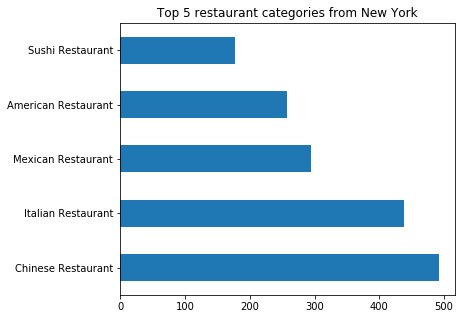

In [21]:
top5gastronomies.plot(kind='barh',figsize=(6,5))
plt.title("Top 5 restaurant categories from New York")
plt.show()

Let's get the top 10 of the neighborhoods with the most restaurants.

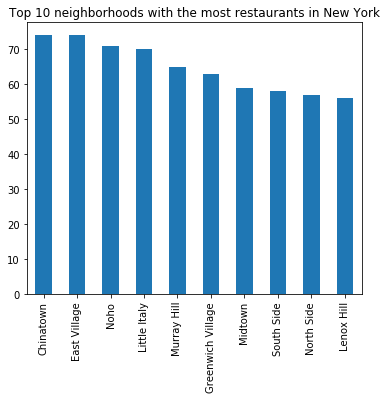

In [22]:
top10neighborhoods=ny_restaurants['Neighborhood'].value_counts()[:10]
top10neighborhoods.plot(kind='bar',figsize=(6,5))
plt.title("Top 10 neighborhoods with the most restaurants in New York")
plt.show()

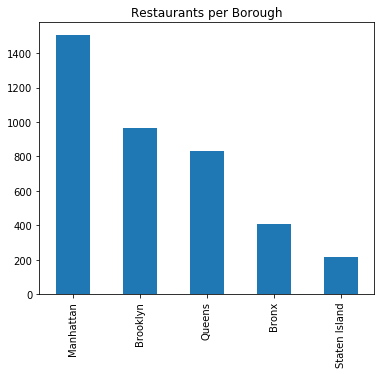

In [23]:
top5borough=ny_restaurants['Borough'].value_counts()
top5borough.plot(kind='bar',figsize=(6,5))
plt.title("Restaurants per Borough")
plt.show()

In [24]:
top5gastronomiesMan=ny_restaurants[ny_restaurants['Borough']=="Manhattan"]['Venue Category'].value_counts()[0:5]
top5gastronomiesMan

Italian Restaurant     206
American Restaurant    123
Chinese Restaurant     102
Mexican Restaurant      98
Sushi Restaurant        80
Name: Venue Category, dtype: int64

In [25]:
top5gastronomiesBro=ny_restaurants[ny_restaurants['Borough']=="Brooklyn"]['Venue Category'].value_counts()[0:5]
top5gastronomiesBro

Chinese Restaurant      131
Italian Restaurant       82
Mexican Restaurant       81
American Restaurant      66
Caribbean Restaurant     52
Name: Venue Category, dtype: int64

In [26]:
top5gastronomiesQ=ny_restaurants[ny_restaurants['Borough']=="Queens"]['Venue Category'].value_counts()[0:5]
top5gastronomiesQ

Chinese Restaurant      130
Korean Restaurant        62
Italian Restaurant       51
Mexican Restaurant       49
Fast Food Restaurant     40
Name: Venue Category, dtype: int64

In [27]:
top5gastronomiesBronx=ny_restaurants[ny_restaurants['Borough']=="Bronx"]['Venue Category'].value_counts()[0:5]
top5gastronomiesBronx

Chinese Restaurant      101
Spanish Restaurant       48
Italian Restaurant       46
Mexican Restaurant       45
Fast Food Restaurant     42
Name: Venue Category, dtype: int64

In [28]:
top5gastronomiesSI=ny_restaurants[ny_restaurants['Borough']=="Staten Island"]['Venue Category'].value_counts()[0:5]
top5gastronomiesSI

Italian Restaurant     53
Chinese Restaurant     28
American Restaurant    24
Mexican Restaurant     21
Sushi Restaurant       15
Name: Venue Category, dtype: int64

### Data Preprocessing

Now transform categorical values (Vanue Category) to numerical values using one hot encoding

In [29]:
ny_onehot = pd.get_dummies(ny_restaurants[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_restaurants[['Neighborhood']]

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Hunan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Romanian Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
7,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,Eastchester,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,Eastchester,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [30]:
ny_grouped = ny_onehot.groupby("Neighborhood").mean().reset_index()
ny_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Hunan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Romanian Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Allerton,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arlington,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arrochar,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.000000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arverne,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Exploring the top 5 restaurants from each neighborhood, checking that their frequency should be higher than 0.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    #get values that are higher than 0
    freq = row_categories_sorted.where(row_categories>0).count()
    #if there are more than num_top_venues, slice and return
    if freq > num_top_venues:
        return row_categories_sorted.index.values[0:num_top_venues]
    #if there are less than num_top_venues, complete the rest of the values with ""
    else:
        return list(row_categories_sorted.index.values[0:freq])+["" for i in range(num_top_venues-freq)]

In [87]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_venues_sorted = pd.DataFrame(columns=columns)
ny_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    ny_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

ny_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Chinese Restaurant,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Spanish Restaurant
1,Annadale,American Restaurant,Sushi Restaurant,,,
2,Arlington,American Restaurant,Peruvian Restaurant,Caribbean Restaurant,,
3,Arrochar,Italian Restaurant,Polish Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,
4,Arverne,Thai Restaurant,,,,


As we can see, some neighborhoods only have one restaurant within a radius of 500.


### Model

Let's use an unsupervised machine learning technique to group these locations. In this case, using K-means, we will create k clusters of neighborhoods that are similar to each other. Specifically, that their gastronomic selections are similar.

In [88]:
# set number of clusters
kclusters = 10

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 2, 2, 6, 8, 8, 6, 6, 9, 7, 8, 6, 7, 8, 9, 8, 1, 9, 6, 6, 6, 9,
       8, 1, 8, 4, 7, 8, 7, 9, 8, 1, 9, 7, 5, 8, 8, 6, 7, 8, 8, 6, 8, 8,
       8, 4, 6, 1, 2, 7, 8, 8, 3, 8, 7, 6, 4, 7, 5, 7, 6, 8, 4, 5, 6, 8,
       8, 8, 6, 9, 9, 7, 4, 4, 8, 7, 5, 1, 8, 6, 0, 6, 8, 6, 5, 9, 8, 7,
       8, 5, 8, 8, 4, 8, 8, 8, 6, 2, 1, 2, 9, 8, 7, 1, 6, 8, 8, 6, 6, 6,
       8, 6, 2, 7, 3, 9, 4, 6, 4, 8, 6, 0, 8, 6, 8, 4, 7, 8, 7, 8, 8, 7,
       9, 8, 4, 7, 5, 7, 6, 0, 6, 9, 8, 8, 7, 4, 8, 2, 7, 9, 8, 8, 9, 2,
       1, 0, 9, 4, 9, 1, 8, 8, 9, 8, 4, 9, 4, 4, 4, 9, 8, 9, 6, 0, 4, 1,
       8, 4, 6, 8, 9, 9, 9, 8, 6, 5, 4, 8, 8, 9, 6, 4, 6, 3, 9, 4, 7, 9,
       8, 9, 5, 7, 9, 4, 9, 8, 9, 5, 4, 2, 7, 8, 4, 8, 9, 9, 7, 5, 9, 3,
       5, 8, 7, 9, 0, 2, 6, 1, 5, 3, 8, 4, 8, 5, 6, 8, 9, 6, 8, 6, 8, 7,
       8, 6, 7, 6, 4, 6, 8, 8, 4, 4, 6, 8, 8, 9, 7, 7, 1, 6, 4, 6, 4, 8,
       5, 8, 1, 9, 4, 8, 2, 6, 8, 6], dtype=int32)

Add the labels to the dataframe

In [89]:
ny_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
ny_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,4,Allerton,Chinese Restaurant,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Spanish Restaurant
1,2,Annadale,American Restaurant,Sushi Restaurant,,,
2,2,Arlington,American Restaurant,Peruvian Restaurant,Caribbean Restaurant,,
3,6,Arrochar,Italian Restaurant,Polish Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,
4,8,Arverne,Thai Restaurant,,,,


Now that the dataframe has the cluster labels, let's join venues to complete the dataframe.

In [90]:
ny_restaurants_merged = neighborhoods

# join venues
ny_restaurants_merged = ny_restaurants_merged.join(ny_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_restaurants_merged.dropna(inplace=True)

# change the cluster labels type to int
ny_restaurants_merged["Cluster Labels"]=ny_restaurants_merged["Cluster Labels"].astype(int)

# display first 5 rows.
ny_restaurants_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Bronx,Co-op City,40.874294,-73.829939,3,Fast Food Restaurant,Chinese Restaurant,,,
2,Bronx,Eastchester,40.887556,-73.827806,5,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,
5,Bronx,Kingsbridge,40.881687,-73.902818,4,Chinese Restaurant,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Fast Food Restaurant
6,Manhattan,Marble Hill,40.876551,-73.910660,2,American Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,,
7,Bronx,Woodlawn,40.898273,-73.867315,2,American Restaurant,Italian Restaurant,Indian Restaurant,,


In [98]:
#save the dataframe
project.save_data("ny_restaurants_merged.csv", ny_restaurants_merged.to_csv(index=False),overwrite = True)

{'file_name': 'ny_restaurants_merged.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'mydatascienceproject-donotdelete-pr-ragnmlzydhebcj',
 'asset_id': '23bccc54-8011-4a6f-b7a2-da3216609e50'}


Then use it to create a map with the diferent zones and restaurants.


In [144]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create a new map of NY
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add neighborhood markers to the map
for lat, lon, poi,cluster in zip(ny_restaurants_merged['Latitude'],
                                 ny_restaurants_merged['Longitude'], 
                                 ny_restaurants_merged['Neighborhood'], 
                                 ny_restaurants_merged['Cluster Labels']):
    label = folium.Popup(str(poi)+" ("+str(cluster)+")", parse_html=True)
    folium.Circle([lat, lon],radius=500,popup=label,color=rainbow[cluster-1],fill=True,fill_opacity=0.50).add_to(map_clusters)

# add venue markers to the map
for lat, lon in zip(ny_restaurants['Venue Latitude'], ny_restaurants['Venue Longitude']):
    folium.CircleMarker([lat, lon], radius=1, color='green',opacity=0.3).add_to(map_clusters)
    
map_clusters

In [93]:
ny_restaurants_merged.groupby('Cluster Labels').count().sort_values('Neighborhood',ascending=True)[['Neighborhood']]

,Neighborhood
Cluster Labels,
3,5
0,6
2,11
1,13
5,15
7,31
4,33
9,38
6,47


Most of the neighbohoods are in clusters from 4 to 8 (more than 15).
Cluster 3, 0, 2 and 1 has the lowest amount of neihborhoods (less than 15).
Let's see how cluster 3 looks.

### Cluster 3

In [148]:
cluster3 = ny_restaurants_merged[ny_restaurants_merged['Cluster Labels'] == 3]
cluster3.loc[:,cluster3.columns[[0,1] +list(range(4, ny_restaurants_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Bronx,Co-op City,3,Fast Food Restaurant,Chinese Restaurant,,,
148,Queens,South Ozone Park,3,Fast Food Restaurant,,,,
237,Staten Island,Pleasant Plains,3,Fast Food Restaurant,,,,
288,Queens,Roxbury,3,Fast Food Restaurant,,,,
302,Queens,Hammels,3,Fast Food Restaurant,,,,


__Cluster 3__ has __5__ neighborhoods where the most common restaurants are __fast food restaurants within a 500 meter radius.__  

__4 out of 5 neighborhoods__ have fast food restaurants as their only restaurants. It seems that those neighborhoods are good places to open a restaurant since there is a lack of other gastronomic topics.    



Let's see Cluster 0.

### Cluster 0

In [149]:
cluster0 = ny_restaurants_merged[ny_restaurants_merged['Cluster Labels'] == 0]
cluster0.loc[:,cluster0.columns[[0,1] +list(range(4, ny_restaurants_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
206,Staten Island,Mariner's Harbor,0,Italian Restaurant,,,,
234,Staten Island,New Dorp Beach,0,Italian Restaurant,,,,
252,Staten Island,Shore Acres,0,Italian Restaurant,Chinese Restaurant,,,
257,Staten Island,Howland Hook,0,Italian Restaurant,,,,
287,Staten Island,Egbertville,0,Italian Restaurant,,,,
292,Staten Island,Lighthouse Hill,0,Italian Restaurant,,,,


__Cluster 0__ has 6 neighborhoods where the most common restaurants are Italian. _All of them located in Staten Island._  

5 out of 6 neihborhoods have only Italian Restaurant within the 500 meter radius. But Italian food is the second most common gastronomy in NY.

### Cluster 2

In [150]:
cluster2 = ny_restaurants_merged[ny_restaurants_merged['Cluster Labels'] == 2]
cluster2.loc[:,cluster2.columns[[0,1] +list(range(4, ny_restaurants_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Manhattan,Marble Hill,2,American Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,,
7,Bronx,Woodlawn,2,American Restaurant,Italian Restaurant,Indian Restaurant,,
27,Bronx,Clason Point,2,American Restaurant,South American Restaurant,,,
202,Staten Island,Grymes Hill,2,American Restaurant,,,,
215,Staten Island,Annadale,2,American Restaurant,Sushi Restaurant,,,
219,Staten Island,Silver Lake,2,American Restaurant,,,,
227,Staten Island,Arlington,2,American Restaurant,Peruvian Restaurant,Caribbean Restaurant,,
251,Staten Island,Richmond Town,2,American Restaurant,Italian Restaurant,,,
279,Brooklyn,Fulton Ferry,2,American Restaurant,Seafood Restaurant,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant
296,Brooklyn,Madison,2,American Restaurant,Italian Restaurant,,,


__Cluster 2__ has a wider variety of restaurants. That group doesn't look as good as the previous ones.

### Cluster 1

In [151]:
cluster1 = ny_restaurants_merged[ny_restaurants_merged['Cluster Labels'] == 1]
cluster1.loc[:,cluster1.columns[[0,1] +list(range(4, ny_restaurants_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
26,Bronx,Soundview,1,Chinese Restaurant,Latin American Restaurant,Spanish Restaurant,,
45,Bronx,Edenwald,1,Chinese Restaurant,,,,
60,Brooklyn,Brownsville,1,Chinese Restaurant,Spanish Restaurant,,,
83,Brooklyn,Marine Park,1,Chinese Restaurant,,,,
144,Queens,Glendale,1,Chinese Restaurant,,,,
158,Queens,Fresh Meadows,1,Chinese Restaurant,Vegetarian / Vegan Restaurant,,,
174,Queens,Beechhurst,1,Chinese Restaurant,Italian Restaurant,,,
209,Staten Island,New Springville,1,Chinese Restaurant,Mexican Restaurant,,,
232,Staten Island,Midland Beach,1,Chinese Restaurant,,,,
267,Bronx,Claremont Village,1,Chinese Restaurant,Fast Food Restaurant,Caribbean Restaurant,,


Like Cluster 2, Cluster 1 has a greater variety of restaurants. These groups correspond to the Chinese restaurants that are the most common and saturated gastronomy in New York.

### Promising neighborhoods

Let's get the amount of restaurants each neighborhood has within these clusters.  
Since I am interested in places where the density of restaurants is low, these neighborhoods will be limited to having less than 3 restaurants.

In [152]:
# function that returns a dataframe with neighborhood that has less than 3 restaurants
def get_restaurants(cluster):
    tmp=ny_restaurants[ny_restaurants['Neighborhood'].isin(cluster['Neighborhood'])].groupby('Neighborhood').count()
    tmp2=cluster.join(tmp['Borough'],on='Neighborhood',rsuffix="_o")
    tmp2.rename(columns={'Borough_o':'N Restaurants'}, inplace=True)
    tmp2=tmp2[tmp2["N Restaurants"]<3]
    return tmp2

In [157]:
clusters=[cluster3,cluster0,cluster2,cluster1]
df_clusters=[]
for cl in clusters:
    df_clusters.append(get_restaurants(cl))

In [158]:
#cluster3
df_clusters[0]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,N Restaurants
148,Queens,South Ozone Park,40.668550,-73.809865,3,Fast Food Restaurant,,,,,2
237,Staten Island,Pleasant Plains,40.524699,-74.219831,3,Fast Food Restaurant,,,,,1
288,Queens,Roxbury,40.567376,-73.892138,3,Fast Food Restaurant,,,,,1
302,Queens,Hammels,40.587338,-73.805530,3,Fast Food Restaurant,,,,,1


In [159]:
#cluster0
df_clusters[1]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,N Restaurants
206,Staten Island,Mariner's Harbor,40.632546,-74.150085,0,Italian Restaurant,,,,,2
257,Staten Island,Howland Hook,40.638433,-74.186223,0,Italian Restaurant,,,,,1
287,Staten Island,Egbertville,40.579119,-74.127272,0,Italian Restaurant,,,,,1
292,Staten Island,Lighthouse Hill,40.576506,-74.137927,0,Italian Restaurant,,,,,1


In [160]:
#cluster2
df_clusters[2]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,N Restaurants
27,Bronx,Clason Point,40.806551,-73.854144,2,American Restaurant,South American Restaurant,,,,2
202,Staten Island,Grymes Hill,40.624185,-74.087248,2,American Restaurant,,,,,1
219,Staten Island,Silver Lake,40.619193,-74.096290,2,American Restaurant,,,,,1
251,Staten Island,Richmond Town,40.569606,-74.134057,2,American Restaurant,Italian Restaurant,,,,2
296,Brooklyn,Madison,40.609378,-73.948415,2,American Restaurant,Italian Restaurant,,,,2
305,Staten Island,Fox Hills,40.617311,-74.081740,2,African Restaurant,American Restaurant,,,,2


In [161]:
#cluster1
df_clusters[3]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,N Restaurants
45,Bronx,Edenwald,40.884561,-73.848083,1,Chinese Restaurant,,,,,1
83,Brooklyn,Marine Park,40.609748,-73.931344,1,Chinese Restaurant,,,,,1
144,Queens,Glendale,40.702762,-73.870742,1,Chinese Restaurant,,,,,1
232,Staten Island,Midland Beach,40.573527,-74.093483,1,Chinese Restaurant,,,,,1
278,Queens,Blissville,40.737251,-73.932442,1,Chinese Restaurant,,,,,1
285,Staten Island,Willowbrook,40.603707,-74.132084,1,Chinese Restaurant,,,,,2


In [172]:
# create a new map of NY
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# set colors for markers
rainbow = ['red','blue','green','cyan']
i=0;
for df in df_clusters:
    # add neighborhood markers to the map
    for lat, lon, poi,cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Cluster Labels']):
        label = folium.Popup(str(poi)+" ("+str(cluster)+")", parse_html=True)
        folium.Circle([lat, lon],radius=500,popup=label,color=rainbow[i],fill=True,fill_opacity=0.50).add_to(map_clusters)
    i+=1
# add neighborhoods that have no restaurants near by.
for lat, lon, poi in zip(no_restaurants_nearby['Latitude'], no_restaurants_nearby['Longitude'], no_restaurants_nearby['Neighborhood']):
        label = folium.Popup(str(poi), parse_html=True)
        folium.Circle([lat, lon],radius=500,popup=label,color='black',fill=True,fill_opacity=0.50).add_to(map_clusters)
        
map_clusters

Here's a map of the neighborhoods that have up to 2 restaurants.  
As you can see, Manhattan has no markers, as Manhattan is one of the most popular borough in New York and is saturated with restaurants, so it would not be an ideal area to open a restaurant in the face of so much competition.  

Brooklyn is probably the second most popular borough and the second most populated. There are 4 neighborhoods with no restaurants nearby and 2 neighborhoods with less than 3 restaurants nearby. 

Queens is the third most populated borough and it is home of two airports, so a lot of tourists pass through there. Blissville is a good neighborhood since is within Long Island City, a residential and commercial area. 
  
The Bronx has many middle-income neighborhoods, such as Wakefield, Fieldstone, Riverdale and Edenwald. These are good areas to open a restaurant since there are no restaurants nearby.

Staten Island is the least populated and mostly suburban of the five boroughs. Although the map show a lot of locations, almost all of them are residential. 